In [1]:

import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
plot_style()
%matplotlib inline



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [8]:
data=np.array(np.load('../simulations{}.npy'.format('rubin_wide'), allow_pickle=True)).flatten()[0]

In [11]:
df= data['data']

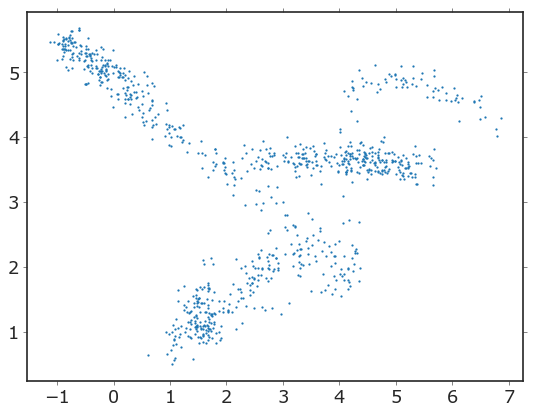

In [16]:
fig, ax=plt.subplots()
ax.scatter(df.LSST_G-df.LSST_R, df.LSST_I-df.LSST_Z, s=1)

In [10]:
data['data']

,abs_LSST_G,abs_LSST_R,abs_LSST_I,abs_LSST_Z,abs_LSST_Y,LSST_G,LSST_R,LSST_I,LSST_Z,LSST_Y,...,RV,mu_alpha_cosdec,mu_delta,Vr,Vphi,Vz,scale_unc,scale_times_model,distance,population
0,16.314776,15.212405,13.213489,12.397849,11.683114,24.963629,23.861259,21.862343,21.046703,20.331968,...,40.083959,-4.433330,-1.620671,-30.646340,-216.394365,-20.921100,0.000002,0.016960,536.748376,thin disk
1,27.466589,23.397743,21.605432,18.514400,17.244433,24.399981,20.331135,18.538824,15.447792,14.177825,...,23.910533,-1463.739577,659.603087,-3.323905,-232.060284,-17.244318,0.000002,0.016960,2.436006,thin disk
2,16.908051,15.841870,13.672765,12.796232,12.313622,24.383174,23.316993,21.147888,20.271356,19.788745,...,-14.205180,-40.313676,6.032256,39.898932,-222.165773,20.789585,0.000002,0.016960,312.625704,thin disk
3,33.893727,27.790597,25.726465,21.182050,19.817636,24.172677,18.069548,16.005416,11.461001,10.096587,...,10.695496,7996.068339,-49974.298373,-29.400764,-225.142597,8.376417,0.000002,0.016960,0.113708,thin disk
4,25.766805,22.059151,19.331981,17.447620,16.523786,24.246719,20.539064,17.811894,15.927534,15.003700,...,5.900094,-419.575148,817.986948,5.594016,-262.738246,9.433473,0.000002,0.016960,4.965726,thin disk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,21.937539,17.671874,15.437134,13.399490,12.580939,21.209836,16.944170,14.709431,12.671787,11.853236,...,-14.326289,249.041844,152.842126,-6.196066,-256.213486,21.735354,0.000002,0.013075,7.152525,halo
933,18.979614,17.025694,13.363387,11.892038,10.914523,24.410395,22.456475,18.794168,17.322819,16.345304,...,48.806146,-16.918040,-21.194176,20.795773,-212.651848,-7.504131,0.000002,0.013075,121.942797,halo
934,20.923449,18.205603,14.876001,12.720968,11.651826,23.123760,20.405914,17.076312,14.921279,13.852137,...,38.936810,-93.703387,130.757776,18.559322,-230.139813,34.165425,0.000002,0.013075,27.546227,halo
935,24.221729,24.427658,19.303161,14.282476,12.270372,15.833934,16.039862,10.915365,5.894680,3.882576,...,69.418716,-63381.376721,-48520.686930,35.750635,-154.807847,-8.858614,0.000002,0.013075,0.210107,halo


In [9]:
#other color and

{'data':      abs_LSST_G  abs_LSST_R  abs_LSST_I  abs_LSST_Z  abs_LSST_Y     LSST_G  \
 0     16.314776   15.212405   13.213489   12.397849   11.683114  24.963629   
 1     27.466589   23.397743   21.605432   18.514400   17.244433  24.399981   
 2     16.908051   15.841870   13.672765   12.796232   12.313622  24.383174   
 3     33.893727   27.790597   25.726465   21.182050   19.817636  24.172677   
 4     25.766805   22.059151   19.331981   17.447620   16.523786  24.246719   
 ..          ...         ...         ...         ...         ...        ...   
 932   21.937539   17.671874   15.437134   13.399490   12.580939  21.209836   
 933   18.979614   17.025694   13.363387   11.892038   10.914523  24.410395   
 934   20.923449   18.205603   14.876001   12.720968   11.651826  23.123760   
 935   24.221729   24.427658   19.303161   14.282476   12.270372  15.833934   
 936   24.019157   23.774004   18.753095   14.025683   12.149201  16.473885   
 
         LSST_R     LSST_I     LSST_Z     